### Code to estimate quarterly TFP growth for Mexico
##### Values printed after the last cell at the bottom of the code

In [ ]:
import pandas as pd
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt

#storm category based on Saffir-Simpson hurrican wind scale https://www.nhc.noaa.gov/aboutsshws.php
storm_cat_dict = {
    "Storm Category": [5, 4, 3, 2, 1, 'no hurricane'],
    "Minimum WS (knots)": [137, 113, 96, 83, 64, 0],
    "Maximum WS (knots)": [137, 136, 112, 95, 82, 63]
}

df_storm_cat = pd.DataFrame(storm_cat_dict)

def calculate_TFP_loss(df):
    '''
    TFP loss calculated based on average of min and max wind speed.
    '''

    beta_max = df['Maximum WS (knots)'] * (-0.0046 / 137)
    beta_min = df['Minimum WS (knots)'] * (-0.0046 / 137)

    return 0.5 * (beta_max + beta_min)

df_storm_cat[r'$\beta_{TFP \, loss}$'] = df_storm_cat.apply(calculate_TFP_loss, axis=1)

# Define the file path and sheet name.
# Make sure that the file is in the same folder as this .ipynb file, otherwise specify path to .xlsx file.
file_path = "public_emdat_custom_request_2025-02-23.xlsx" 
sheet_name = "EM-DAT Data"

# Read the specified sheet into a Pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

columns_to_extract = ["Disaster Type", "Event Name", "ISO", "Magnitude", "Magnitude Scale", "Start Year", "Total Damage, Adjusted ('000 US$)"]  

def assign_storm_category(df):
    '''
    Assign storm categories 1 to 5 to storm based on its magnitude (knots).
    '''

    if df['Magnitude (knots)'] >= 136:
        return 5
    if df['Magnitude (knots)'] >= 113 and df['Magnitude (knots)'] < 136:
        return 4
    if df['Magnitude (knots)'] >= 96 and df['Magnitude (knots)'] <= 112:
        return 3
    if df['Magnitude (knots)'] >= 83 and df['Magnitude (knots)'] <= 95:
        return 2
    if df['Magnitude (knots)'] >= 64 and df['Magnitude (knots)'] <= 82:
        return 1
    if df['Magnitude (knots)'] < 64:
        return 'no hurricane'

# Extract the selected columns into a new DataFrame
df_selected = df[columns_to_extract]

# Ensure we are working with a copy to avoid SettingWithCopyWarning
df_selected = df_selected.copy()

df_selected.dropna(subset=["Magnitude"], inplace=True)
df_selected.dropna(subset=["Total Damage, Adjusted ('000 US$)"], inplace=True)
df_selected['Total Damage (US$)'] = df_selected["Total Damage, Adjusted ('000 US$)"] * 1000
df_selected.rename(columns={'Start Year': 'year'}, inplace=True)
df_selected['Magnitude (knots)'] = df_selected['Magnitude'].apply(lambda x: x/1.852)
df_selected['Storm Category'] = df_selected.apply(assign_storm_category, axis=1)
df_selected_mex = df_selected.loc[df_selected['ISO'] == 'MEX']
df_selected_mex_merged = pd.merge(df_selected_mex, df_storm_cat, on='Storm Category', how='left').drop(columns=['Minimum WS (knots)', 'Maximum WS (knots)', "Total Damage, Adjusted ('000 US$)"])
df_selected_mex_merged_grouped = df_selected_mex_merged.groupby('year', as_index=False)[["Total Damage (US$)", r"$\beta_{TFP \, loss}$"]].sum()

display(Markdown(df_selected_mex_merged_grouped.to_markdown()))

|    |   year |   Total Damage (US$) |   $\beta_{TFP \, loss}$ |
|---:|-------:|---------------------:|------------------------:|
|  0 |   1988 |          6.44144e+08 |             -0.00245109 |
|  1 |   1995 |          4.84837e+09 |             -0.00350876 |
|  2 |   1997 |          8.57632e+08 |             -0.00565766 |
|  3 |   2000 |          1.769e+06   |             -0.00245109 |
|  4 |   2001 |          6.88332e+08 |             -0.00245109 |
|  5 |   2002 |          1.42293e+09 |             -0.00767226 |
|  6 |   2003 |          1.65636e+08 |             -0.00298832 |
|  7 |   2005 |          3.9162e+09  |             -0.00350876 |
|  8 |   2006 |          4.081e+06   |             -0.00418029 |
|  9 |   2007 |          8.81735e+08 |             -0.0046     |
| 10 |   2008 |          1.06142e+08 |             -0.00298832 |
| 11 |   2009 |          5.6811e+07  |             -0.00349197 |
| 12 |   2010 |          8.24442e+09 |             -0.00594307 |
| 13 |   2011 |          7.1482e+08  |             -0.00404599 |
| 14 |   2012 |          7.36559e+08 |             -0.00245109 |
| 15 |   2014 |          3.26858e+09 |             -0.0122219  |
| 16 |   2015 |          1.05802e+09 |             -0.0046     |

/var/folders/jf/6g1mfg3d7m16wdt3vrsgj2b00000gn/T/ipykernel_18131/3397927417.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mexico["TFP Pct_Change"] = df_mexico["TFP"].pct_change()


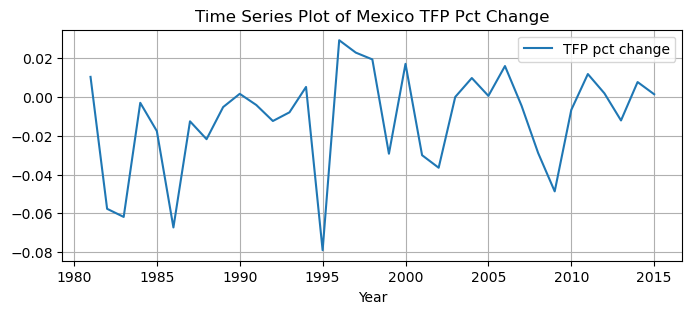

In [2]:
# Define the file path and sheet name.
# Make sure that the file is in the same folder as this .ipynb file, otherwise specify path to .xlsx file.
file_path = "pwt1001.xlsx" 
sheet_name = "Data"

# Read the specified sheet into a Pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# List of columns to extract
#rgdpna: real GDP at constant 2017 national prices, rnna: capital stock at constant 2017 national prices; both in Mio. 2017 US$
#rtfpna: TFP at constant national prices (2017=1)
columns_to_extract = ["year", "country", "rgdpna", "rnna", "rtfpna"]  

# Dictionary mapping old column names to new ones
rename_dict = {
    "rgdpna": "realGDP",
    "rnna": "CapitalStock",
    "rtfpna": "TFP"
}

# Extract the selected columns into a new DataFrame
df_selected = df[columns_to_extract]

# Ensure we are working with a copy to avoid SettingWithCopyWarning
df_selected = df_selected.copy()

# Rename the columns
df_selected = df_selected.rename(columns=rename_dict)

#convert "year" column to datetime format, to be able to plot afterwards 
df_selected["year"] = pd.to_datetime(df_selected["year"].astype(str), format='%Y')
df_selected["year"] = df_selected["year"].dt.year.astype(int)
df_selected = df_selected[(df_selected["year"] >= 1980) & (df_selected["year"] < 2016)]
df_selected.set_index("year", inplace=True)

#If the columns contain text (e.g., "NaN", "missing", or other non-numeric values), convert them to numeric. 
#The errors='coerce' argument will replace non-numeric values with NaN instead of failing.
# List of columns to convert
columns_to_convert = ["realGDP", "CapitalStock", "TFP"]

# Convert selected columns to numeric, coercing errors to NaN if necessary
df_selected[columns_to_convert] = df_selected[columns_to_convert].apply(pd.to_numeric, errors="coerce")

#Real GDP & capital stock are reported in 2017 $. Therefore, convert to 2021 $ to make it comparable to EM-DAT data; use World Bank values.
#Source: https://databank.worldbank.org/metadataglossary/world-development-indicators/series/NY.GDP.DEFL.ZS
gdp_deflator_2017 = 95.0529682857042  # 2017 deflator
gdp_deflator_2018 = 100.0  # 2018 is the base year (no change)
gdp_deflator_2021 = 114.036428056835  # 2021 deflator

df_selected['realGDP'] = df_selected['realGDP'] * 1_000_000 * gdp_deflator_2021/gdp_deflator_2017
df_selected['CapitalStock'] = df_selected['CapitalStock'] * 1_000_000 * gdp_deflator_2021/gdp_deflator_2017

df_selected['ln_realGDP'] = df_selected['realGDP'].apply(np.log)
df_selected['ln_CapitalStock'] = df_selected['CapitalStock'].apply(np.log)

df_mexico = df_selected.loc[df_selected["country"] == "Mexico"]
df_philippines = df_selected.loc[df_selected["country"] == "Philippines"]

df_mexico["TFP Pct_Change"] = df_mexico["TFP"].pct_change()

# Plot TFP time evolution of Mexico
plt.figure(figsize=(8, 3))
plt.plot(df_mexico.index, df_mexico['TFP Pct_Change'], linestyle='-', label='TFP pct change')
plt.title(f"Time Series Plot of Mexico TFP Pct Change")
plt.xlabel("Year")
#plt.ylabel("TFP at const. National Prices (2017=1)")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
df_selected_mex_merged_final = pd.merge(df_mexico, df_selected_mex_merged_grouped, on='year', how='left')
df_selected_mex_merged_final["Total Damage (US$)"] = df_selected_mex_merged_final["Total Damage (US$)"].fillna(0)
df_selected_mex_merged_final[r'$\beta_{TFP \, loss}$'] = df_selected_mex_merged_final[r'$\beta_{TFP \, loss}$'].fillna(0)
df_selected_mex_merged_final['d_t_CapitalStock'] = df_selected_mex_merged_final["Total Damage (US$)"] / df_selected_mex_merged_final['CapitalStock']

def compute_lnTFP_CapitalStock_damage(df_country):
    
    alpha = 2 / 3

    return 1 / (1-alpha) * (df_country['ln_realGDP'] + alpha * df_country["d_t_CapitalStock"] - alpha * df_country['ln_CapitalStock'])

df_selected_mex_merged_final['lnTFP_estimated_CapitalStock'] = compute_lnTFP_CapitalStock_damage(df_selected_mex_merged_final)

#divide by 4 to adjust to quarterly values
df_selected_mex_merged_final['TFP_estimated_CapitalStock_pct_change'] = df_selected_mex_merged_final['lnTFP_estimated_CapitalStock'].apply(np.exp).pct_change() / 4

display(Markdown(df_selected_mex_merged_final.to_markdown()))

|    |   year | country   |     realGDP |   CapitalStock |      TFP |   ln_realGDP |   ln_CapitalStock |   TFP Pct_Change |   Total Damage (US$) |   $\beta_{TFP \, loss}$ |   d_t_CapitalStock |   lnTFP_estimated_CapitalStock |   TFP_estimated_CapitalStock_pct_change |
|---:|-------:|:----------|------------:|---------------:|---------:|-------------:|------------------:|-----------------:|---------------------:|------------------------:|-------------------:|-------------------------------:|----------------------------------------:|
|  0 |   1980 | Mexico    | 1.18617e+12 |    4.03676e+12 | 1.50481  |      27.8018 |           29.0265 |    nan           |          0           |              0          |        0           |                        25.3523 |                           nan           |
|  1 |   1981 | Mexico    | 1.29049e+12 |    4.40692e+12 | 1.52045  |      27.886  |           29.1142 |      0.0103906   |          0           |              0          |        0           |                        25.4297 |                             0.0201159   |
|  2 |   1982 | Mexico    | 1.28136e+12 |    4.67191e+12 | 1.43279  |      27.8789 |           29.1726 |     -0.0576521   |          0           |              0          |        0           |                        25.2917 |                            -0.0322409   |
|  3 |   1983 | Mexico    | 1.22632e+12 |    4.79673e+12 | 1.3442   |      27.835  |           29.199  |     -0.0618334   |          0           |              0          |        0           |                        25.1072 |                            -0.0421117   |
|  4 |   1984 | Mexico    | 1.27046e+12 |    4.94075e+12 | 1.34017  |      27.8704 |           29.2285 |     -0.00299398  |          0           |              0          |        0           |                        25.1541 |                             0.0120105   |
|  5 |   1985 | Mexico    | 1.30568e+12 |    5.11286e+12 | 1.31663  |      27.8977 |           29.2628 |     -0.0175697   |          0           |              0          |        0           |                        25.1677 |                             0.00341147  |
|  6 |   1986 | Mexico    | 1.25667e+12 |    5.23535e+12 | 1.22806  |      27.8595 |           29.2865 |     -0.0672652   |          0           |              0          |        0           |                        25.0055 |                            -0.0374183   |
|  7 |   1987 | Mexico    | 1.27999e+12 |    5.35459e+12 | 1.21267  |      27.8779 |           29.309  |     -0.0125326   |          0           |              0          |        0           |                        25.0157 |                             0.00254322  |
|  8 |   1988 | Mexico    | 1.29593e+12 |    5.49545e+12 | 1.1863   |      27.8902 |           29.3349 |     -0.0217459   |          6.44144e+08 |             -0.00245109 |        0.000117214 |                        25.0011 |                            -0.00361549  |
|  9 |   1989 | Mexico    | 1.35033e+12 |    5.64041e+12 | 1.18015  |      27.9314 |           29.361  |     -0.00518388  |          0           |              0          |        0           |                        25.0722 |                             0.018414    |
| 10 |   1990 | Mexico    | 1.41877e+12 |    5.7821e+12  | 1.1821   |      27.9808 |           29.3858 |      0.00164558  |          0           |              0          |        0           |                        25.1709 |                             0.0259345   |
| 11 |   1991 | Mexico    | 1.47868e+12 |    5.94763e+12 | 1.17722  |      28.0222 |           29.414  |     -0.00412368  |          0           |              0          |        0           |                        25.2385 |                             0.0174879   |
| 12 |   1992 | Mexico    | 1.53233e+12 |    6.13554e+12 | 1.16266  |      28.0578 |           29.4451 |     -0.0123703   |          0           |              0          |        0           |                        25.2832 |                             0.011434    |
| 13 |   1993 | Mexico    | 1.58679e+12 |    6.36956e+12 | 1.15347  |      28.0927 |           29.4826 |     -0.0079014   |          0           |              0          |        0           |                        25.3131 |                             0.00758857  |
| 14 |   1994 | Mexico    | 1.6652e+12  |    6.65377e+12 | 1.15946  |      28.141  |           29.5262 |      0.00519046  |          0           |              0          |        0           |                        25.3705 |                             0.0147648   |
| 15 |   1995 | Mexico    | 1.56044e+12 |    6.74107e+12 | 1.06785  |      28.076  |           29.5392 |     -0.0790098   |          4.84837e+09 |             -0.00350876 |        0.000719229 |                        25.1509 |                            -0.0492833   |
| 16 |   1996 | Mexico    | 1.66613e+12 |    6.9002e+12  | 1.09912  |      28.1415 |           29.5626 |      0.0292864   |          0           |              0          |        0           |                        25.2994 |                             0.0400256   |
| 17 |   1997 | Mexico    | 1.7802e+12  |    7.11332e+12 | 1.12429  |      28.2077 |           29.593  |      0.0228998   |          8.57632e+08 |             -0.00565766 |        0.000120567 |                        25.4375 |                             0.0370181   |
| 18 |   1998 | Mexico    | 1.87213e+12 |    7.35803e+12 | 1.14609  |      28.2581 |           29.6268 |      0.0193834   |          0           |              0          |        0           |                        25.5207 |                             0.0216793   |
| 19 |   1999 | Mexico    | 1.92368e+12 |    7.61288e+12 | 1.11255  |      28.2853 |           29.6609 |     -0.0292605   |          0           |              0          |        0           |                        25.5341 |                             0.00337066  |
| 20 |   2000 | Mexico    | 2.01876e+12 |    7.87515e+12 | 1.13159  |      28.3335 |           29.6947 |      0.0171123   |          1.769e+06   |             -0.00245109 |        2.24631e-07 |                        25.611  |                             0.020006    |
| 21 |   2001 | Mexico    | 2.0106e+12  |    8.07524e+12 | 1.09763  |      28.3295 |           29.7198 |     -0.0300094   |          6.88332e+08 |             -0.00245109 |        8.52398e-05 |                        25.5489 |                            -0.0150684   |
| 22 |   2002 | Mexico    | 2.0098e+12  |    8.2503e+12  | 1.0576   |      28.3291 |           29.7413 |     -0.0364739   |          1.42293e+09 |             -0.00767226 |        0.00017247  |                        25.505  |                            -0.0107411   |
| 23 |   2003 | Mexico    | 2.03887e+12 |    8.42097e+12 | 1.05762  |      28.3434 |           29.7617 |      2.38961e-05 |          1.65636e+08 |             -0.00298832 |        1.96695e-05 |                        25.5068 |                             0.000456209 |
| 24 |   2004 | Mexico    | 2.1188e+12  |    8.61673e+12 | 1.06798  |      28.3819 |           29.7847 |      0.00979061  |          0           |              0          |        0           |                        25.5762 |                             0.0179586   |
| 25 |   2005 | Mexico    | 2.1677e+12  |    8.83372e+12 | 1.0686   |      28.4047 |           29.8096 |      0.000581661 |          3.9162e+09  |             -0.00350876 |        0.000443324 |                        25.5958 |                             0.00494651  |
| 26 |   2006 | Mexico    | 2.26514e+12 |    9.0863e+12  | 1.08567  |      28.4487 |           29.8378 |      0.0159724   |          4.081e+06   |             -0.00418029 |        4.49138e-07 |                        25.6704 |                             0.0193741   |
| 27 |   2007 | Mexico    | 2.31704e+12 |    9.35818e+12 | 1.08079  |      28.4713 |           29.8673 |     -0.00448787  |          8.81735e+08 |             -0.0046     |        9.42208e-05 |                        25.6796 |                             0.00230769  |
| 28 |   2008 | Mexico    | 2.34354e+12 |    9.65747e+12 | 1.04962  |      28.4827 |           29.8988 |     -0.0288457   |          1.06142e+08 |             -0.00298832 |        1.09907e-05 |                        25.6506 |                            -0.00714974  |
| 29 |   2009 | Mexico    | 2.21967e+12 |    9.87438e+12 | 0.998544 |      28.4284 |           29.921  |     -0.0486579   |          5.6811e+07  |             -0.00349197 |        5.75337e-06 |                        25.4432 |                            -0.0468162   |
| 30 |   2010 | Mexico    | 2.33327e+12 |    1.0108e+13  | 0.991899 |      28.4783 |           29.9443 |     -0.00665501  |          8.24442e+09 |             -0.00594307 |        0.000815633 |                        25.5478 |                             0.0275657   |
| 31 |   2011 | Mexico    | 2.41874e+12 |    1.03756e+13 | 1.00365  |      28.5143 |           29.9705 |      0.0118446   |          7.1482e+08  |             -0.00404599 |        6.88942e-05 |                        25.602  |                             0.0139155   |
| 32 |   2012 | Mexico    | 2.50684e+12 |    1.06616e+13 | 1.00554  |      28.55   |           29.9977 |      0.00188616  |          7.36559e+08 |             -0.00245109 |        6.9085e-05  |                        25.6549 |                             0.0135917   |
| 33 |   2013 | Mexico    | 2.54078e+12 |    1.09116e+13 | 0.993381 |      28.5635 |           30.0208 |     -0.0120926   |          0           |              0          |        0           |                        25.6488 |                            -0.00152762  |
| 34 |   2014 | Mexico    | 2.61203e+12 |    1.11693e+13 | 1.00105  |      28.5912 |           30.0442 |      0.00771725  |          3.26858e+09 |             -0.0122219  |        0.00029264  |                        25.6857 |                             0.0093888   |
| 35 |   2015 | Mexico    | 2.69792e+12 |    1.14534e+13 | 1.00247  |      28.6235 |           30.0693 |      0.00142354  |          1.05802e+09 |             -0.0046     |        9.23763e-05 |                        25.7321 |                             0.0118768   |

In [ ]:
stats_TFP_from_CapitalStock_damage = df_selected_mex_merged_final['TFP_estimated_CapitalStock_pct_change'].describe()

mean_TFP_from_CapitalStock_damage = stats_TFP_from_CapitalStock_damage['mean']
std_dev_TFP_from_CapitalStock_damage = stats_TFP_from_CapitalStock_damage['std']

print(f"Quarterly mean of TFP growth from capital stock damage: {mean_TFP_from_CapitalStock_damage} & respective std dev: {std_dev_TFP_from_CapitalStock_damage}")

Quarterly mean of TFP growth from capital stock damage: 0.0037489482945105308 & respective std dev: 0.022354611856704388
